# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


def get_calibration_parameters():
    """
    get parameters for camera calibration from chessboard images
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints    


## Apply a distortion correction to raw images

In [2]:
def get_undistorted_image(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[0:2], None, None)
    return cv2.undistort(image, mtx, dist)

In [3]:
def show_processed_images(original, processed):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(processed, cmap='gray')
    ax2.set_title('Processed Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

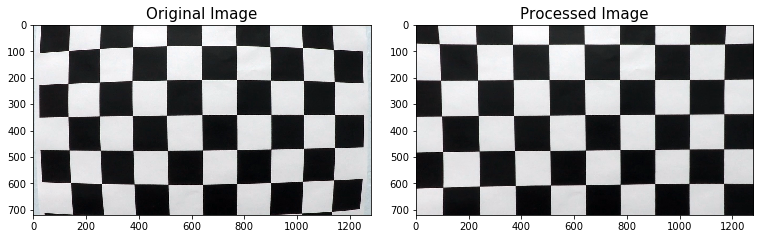

In [4]:
image = cv2.imread("camera_cal/calibration1.jpg")
objpoints, imgpoints = get_calibration_parameters()
undistorted = get_undistorted_image(image, objpoints, imgpoints)
show_processed_images(image, undistorted)

## Create a thresholded binary image

In [5]:
def get_color_threshold_binary_image(image, thresh=(90, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

    
def get_magnitude_threshold_binary_image(image, sobel_kernel=3, thresh=(30, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def get_dicrection_threshold_binary_image(image, sobel_kernel=15, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    gradmag = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

In [6]:
def get_binary_image(image):
    """
    Create thresholded binary image using color and gradient
    """
    color_th_binary = get_color_threshold_binary_image(image)
    mag_th_binary = get_magnitude_threshold_binary_image(image, sobel_kernel=9, thresh=(45, 255))
    dic_th_binary = get_dicrection_threshold_binary_image(image)

    binary_image = np.zeros_like(color_th_binary)
    binary_image[(color_th_binary == 1) & (mag_th_binary == 1) & (dic_th_binary == 1)] = 1

    return binary_image

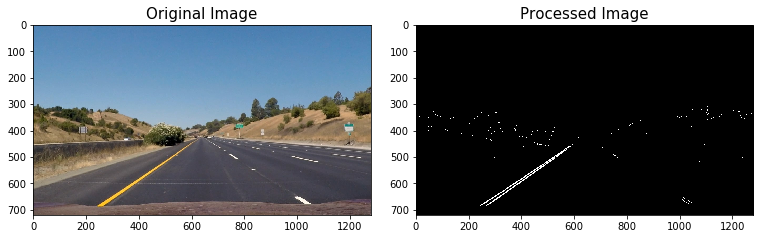

In [7]:
image = mpimg.imread('test_images/straight_lines1.jpg')
processed = get_binary_image(image)
show_processed_images(image, processed)

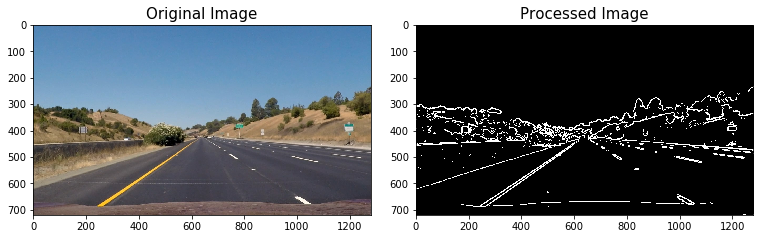

In [8]:
image = mpimg.imread('test_images/straight_lines1.jpg')
processed = get_magnitude_threshold_binary_image(image, sobel_kernel=9, thresh=(45, 255))
show_processed_images(image, processed)

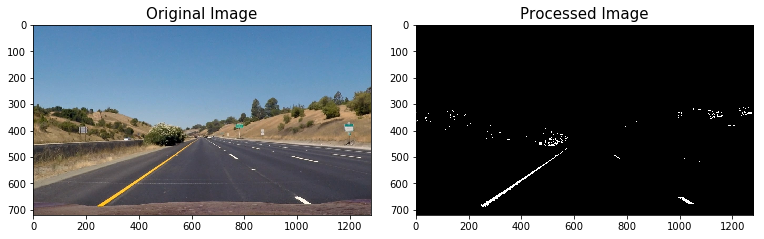

In [9]:
image = mpimg.imread('test_images/straight_lines1.jpg')
processed = get_color_threshold_binary_image(image, thresh=(170, 255))
show_processed_images(image, processed)

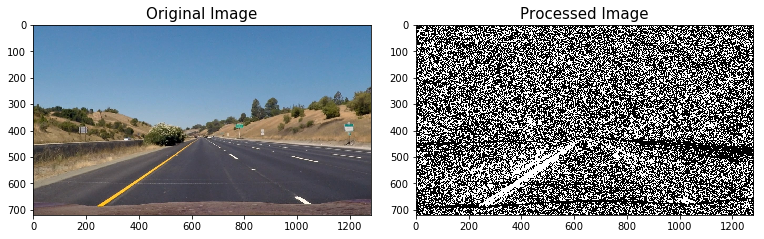

In [10]:
image = mpimg.imread('test_images/straight_lines1.jpg')
processed = get_dicrection_threshold_binary_image(image)
show_processed_images(image, processed)